**Specify here the path to your files (Log, DCD, PDB):**




In [2]:
log_file= 'D1D5_1000mms_1_0-70ns.log'
dcd_file='D1D5_1000mms_1_0-70ns_dry.dcd'
pdb_file='D1D5_eq1_dry.pdb'

### Install the required packages

In [3]:
!pip install ProDy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 41.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 58.2 MB/s eta 0:00:00
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Created wheel for ProDy: filename=ProDy-2.4.1-cp310-cp310-linux_x86_64.whl size=22368525 sha256=e44f51812621429cb4523030b8f35ffb7ed31b7654def38dc2109fb8e556d598
  Stored in directory: /root/.cache/pip/wheels/00/ec/aa/f2842cee2805f22126b5ed9a11d46984f0c116262ccb54b83e
Successfully built ProDy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into

## 1) Parse the log file and plot the force versus time and force versus displacement (or distance) profiles:

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import scipy.signal as signal
import collections
import heapq
import re
from prody import *
import matplotlib.pylab as plt

In [5]:

def extract_info_from_smd_log (log_file):

    output_file='log.txt'
    output_energies= 'energies.txt'
    dico={}
    force_tcl=[]
    energy_parms={}
    F_tcl=[]
    with open(log_file,"r") as file_one , open(output_file, "w") as output,  open(output_energies, "w") as outputE :
        patrn = "SMD  "
        for line in file_one:
            if re.search(patrn, line):
                output.write(line)

            if  re.search('SMD DIRECTION ', line):
                direction=line.split(' ')
                direction=np.array([float(direction[5]),float(direction[6]),float(direction[7])])
                #reshape matrix to be able to do the dot product later
                direction.reshape(3,1)
                print('direction of pulling [x, y, z]: ', direction)

            if re.search('ENERGY:', line) and 'Info:' not in line:
                outputE.write(line)

            if re.search('SMD VELOCITY', line ):
                velocity=line.split()
                smd_vel=float(velocity[3]) / 2 *10**15*10**-10   #smd velocity in nm/ns
                print('pulling speed: ', smd_vel, "nm/ns")

                #extract spring constant and convert it
            if re.search('SMD K' , line ) and 'K2' not in line :
                 smd_k_namd=line.split()

                 smd_k=float(smd_k_namd[3])*69.479*10 #convert pN/nm

            if re.search('TCL', line) and ('Suspending') not in line and ('Running') not in line and ('ACTIVE') not in line and ('FILE') not in line :
                F_tcl= line.split()[-1]
                force_tcl.append(float(F_tcl)*-69.479) #add force of pulling into dictionnary of information

    raw_df= pd.read_csv(output_file,sep=' ', header=None)
    raw_df_energies= pd.read_csv(output_energies, skipinitialspace=True, sep=' ', engine='python', header=None)

    F= np.dot(raw_df.iloc[:, [6,7,8]] ,direction)
    dico["F[pN]"]=F
    dico['timeStep']= raw_df.iloc[:, 2]
    dico['timeInS']= dico['timeStep'] * 2 * 10**-15  #two fem to seconds
    dico['displacement[nm]']=  dico['timeInS'] *10**9 *smd_vel #time in ns multiplied by velocity (nm/ns)

    df = pd.DataFrame.from_dict(dico)
    if len(force_tcl) != 0:
        df.loc[:,'-F[pN]'] = pd.Series(force_tcl)

    df.loc[:,'velocitynmns'] = pd.Series(round(smd_vel,4))
    df.loc[:,'direction'] = pd.Series(direction)

    df.loc[:,'kInpNnm'] = pd.Series(smd_k)
    energy_parms['timeStep']= raw_df_energies.iloc[:,1]
    energy_parms['BOND']= raw_df_energies.iloc[:,2]
    energy_parms['ANGLE']= raw_df_energies.iloc[:,3]
    energy_parms['DIHED']= raw_df_energies.iloc[:,4]
    energy_parms['IMPRP']= raw_df_energies.iloc[:,5]
    energy_parms['ELECT']= raw_df_energies.iloc[:,6]
    energy_parms['VDW']= raw_df_energies.iloc[:,7]
    energy_parms['BOUNDARY']= raw_df_energies.iloc[:,8]
    energy_parms['MISC']= raw_df_energies.iloc[:,9]
    energy_parms['KINETIC']= raw_df_energies.iloc[:,10]
    energy_parms['TOTAL']= raw_df_energies.iloc[:,11]
    energy_parms['TEMP']= raw_df_energies.iloc[:,12]
    energy_parms['POTENTIAL']= raw_df_energies.iloc[:,13]
    energy_parms['TOTAL3']= raw_df_energies.iloc[:,14]
    energy_parms['TEMPAVG']= raw_df_energies.iloc[:,15]
    energy_parms['PRESSURE']= raw_df_energies.iloc[:,16]
    energy_parms['GPRESSURE']= raw_df_energies.iloc[:,17]
    energy_parms['VOLUME']= raw_df_energies.iloc[:,18]
    energy_parms['PRESSAVG']= raw_df_energies.iloc[:,19]
    energy_parms['GPRESSAVG']= raw_df_energies.iloc[:,20]

    energy_parms['timeInS']= energy_parms['timeStep'] * 2* 10**-15
    df_eparms = pd.DataFrame.from_dict(energy_parms)
    return df_eparms, df, smd_vel

In [6]:
df_energy_parms, df, velocity = extract_info_from_smd_log(log_file)

pulling speed:  1.0 nm/ns
direction of pulling [x, y, z]:  [0.0524052 0.379537  0.923691 ]
pulling speed:  1.0 nm/ns
direction of pulling [x, y, z]:  [0.0524052 0.379537  0.923691 ]
pulling speed:  1.0 nm/ns
direction of pulling [x, y, z]:  [0.0524052 0.379537  0.923691 ]


In [7]:
print('SMD forces: ', df['F[pN]'])

SMD forces:  0        -0.003036
1        20.347057
2        41.106600
3         8.402818
4        60.161797
          ...     
698    1417.161227
699    1448.883272
700    1441.043939
701    1437.883798
702    1460.520942
Name: F[pN], Length: 703, dtype: float64


Text(0.5, 0, 'time in seconds')

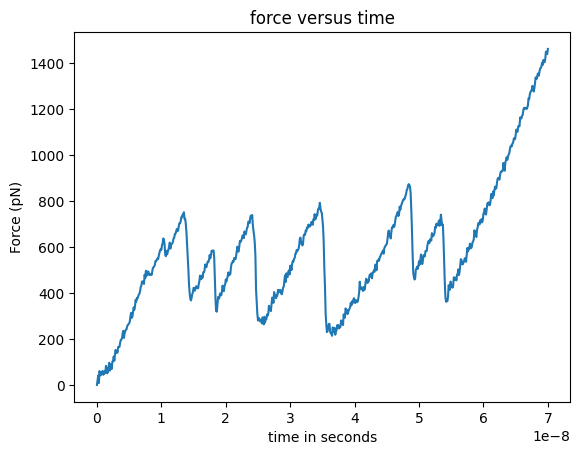

In [8]:
plt.plot(df['timeInS'], df['F[pN]'])
plt.title('force versus time')
plt.ylabel('Force (pN)')
plt.xlabel('time in seconds')

Text(0.5, 0, 'Displacmeent (nm)')

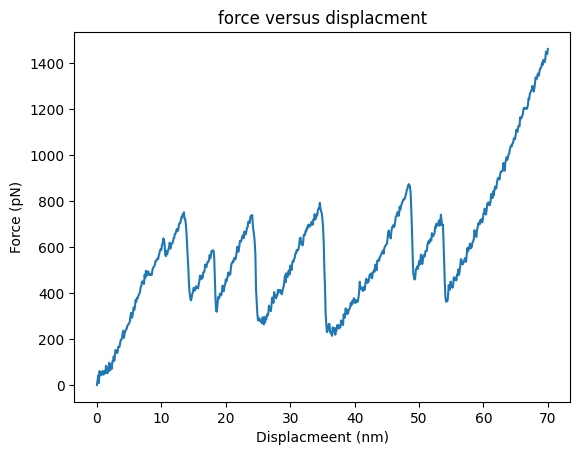

In [9]:
plt.plot(df['displacement[nm]'], df['F[pN]'])
plt.title('force versus displacment')
plt.ylabel('Force (pN)')
plt.xlabel('Displacmeent (nm)')

## 2) Peak detection:

In [10]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float
        Minimum of interval containing the knots.
    maxval: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.
    max: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

def find_peaks(f,ts, knots, **kwargs):
    """
    Parameters
    ----------
    ts : table of info extracted from log (type= pandas.df)
    knots : int
        The knots
    **kwargs : int
        The threshold of prominence.

    Returns
    -------
    df : data frame
        data frame of data.
    smooth : array of smooth data

    peaks:list
        list of all detected peaks
    prominences : array
        array of all prominences

    """

   # energy_parms,df=extract_info_from_smd_log(input_file)
    prominence = kwargs.get('prominence', None)
    model = get_natural_cubic_spline_model(ts, f, minval=min(ts), maxval=max(ts), n_knots=knots)
    smooth = model.predict(ts)
    #peaks detection using find_peaks function from scipy signal library
    peaks=signal.find_peaks(smooth,prominence=prominence)[0] #using find peaks from signal
    prominences = signal.peak_prominences(smooth, peaks)[0]

    return smooth, list(peaks), prominences

def get_slopes(displacement, ts, f, peaks, distance):
    """
    Parameters
    ----------
    displacement : pd dataframe
        contains the displacement in nanometer.
    ts : pd dataframe
        time in seconds .
    f : pd dataframe
        force in pN.
    peaks : list
        list of peaks ( the indexes of peaks).
    distance : float
        distance in nanometer set in the entry of the interface by the user.

    Returns
    -------
    d : dict
        dictionnary of information.
    slope : list
        list containing the loading rates the slopes.
    intercept : list
        list containing the intercepts of the slopes.

    """

    displacement=np.array(displacement)
    d={'f':[], 'ts':[], 'dis1':[], 'disTMP':[], 'dis2':[], 'index_dis2':[], 'peaks':[]}
    #iterate over all peaks
    for i in peaks:
        d['f'].append(f[i])
        d['ts'].append(ts[i])
        #compute displacement using corresponding peak index
        d['dis1'].append(displacement[i])
    #compute selected value = displacement[peak_index]-distance given by the user in nm
    for i in range(len(peaks)):
        d['disTMP'].append(d['dis1'][i]-distance*1)

    #search for closest value to selected one (selected one is distance before peak)
    for i in range(len(peaks)):
        d['dis2'].append(displacement.flat[np.abs(displacement - d['disTMP'][i]).argmin()])
    #put found values in dictionnary of info
    for i in range(len(peaks)):
        d['index_dis2'].append(int(list(displacement).index(d['dis2'][i])))

    for i in peaks:
        d['peaks'].append(int(i))

    slope=[]
    intercept=[]

    #slopes and intercept computing
    for i in range(len(peaks)):
        slope.append(np.polyfit(np.array(ts[d['index_dis2'][i]:d['peaks'][i]]),np.array(f[d['index_dis2'][i]:d['peaks'][i]]), 1)[0])
        intercept.append(np.polyfit(np.array(ts[d['index_dis2'][i]:d['peaks'][i]]),np.array(f[d['index_dis2'][i]:d['peaks'][i]]), 1)[1])
    return d, slope, intercept



**Here you have to specify which forces you will be analyzing next**


If you want to persue the analysis on TCL forces, you have to comment the last line below:

In [11]:
#TCL forces: uncomment this you do not have TCL forces
try:
  df['-F[pN]']
  force=df['-F[pN]']
except:
  print('No TCL forces have been recorded')

#SMD forces:
#comment if you want to persue analysis on TCL forces
force= df['F[pN]']

No TCL forces have been recorded


<ipython-input-12-ac51516fc016>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  total_displacement=float(df['displacement[nm]'].iloc[[-1]])


Text(0, 0.5, 'force (pN)')

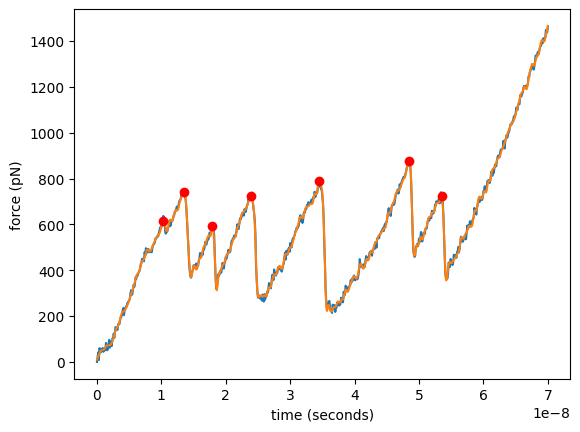

In [12]:
total_displacement=float(df['displacement[nm]'].iloc[[-1]])
#Default knots: you are free to modify it
knots=int( total_displacement  // 0.3 )

all_peaks=signal.find_peaks(force)[0]
prominences=signal.peak_prominences(force, all_peaks)[0]
#Default prominence: you are free to modify it
prominence= int(np.mean(prominences))

smoothed_data, peaks, prominences= find_peaks(force, df['timeInS'], knots= knots, prominence= prominence)


#plot raw data
plt.plot(df['timeInS'], force )
#plot smoothing and detect peaks:
plt.plot(df['timeInS'], smoothed_data )
#plot the detected peaks:
plt.plot(df['timeInS'][peaks], smoothed_data[peaks], "or")
plt.xlabel('time (seconds)')
plt.ylabel('force (pN)')

#### 3) Loading Rate [pN/s] and Stiffnes [pN/nm]

The default distance at which the loading rates are calculated is 1 nm,

 **you can change this distance parameter below:**

In [13]:
def extension_domain(dcd_file, structure, ts, f, coord1, coord2, **kwargs):
    """
    parameters:
        - DCD file of trajectory: it is the file that contains all atom positions at each time step
        - PDB file of structure: downloadale from PDB (Protein Data Bank)
        - Log file of SMD simulation
        - coord1 (string parameter) is the start coordinate of the selection (e.g. start of domain )
        - coord2 (string parameter) is the end coordinate of the selection (e.g end of domain)

    returns:
        This function returns 3 parameters:
            - e2e (type: numpy array) : extension from element to element in nanometer.
            - timeInS: time in seconds
            -f: force in pN
    """
    dcd1 = kwargs.get('additional dcd file 1', None)
    dcd2 = kwargs.get('additional dcd file 2', None)
    dcd3 = kwargs.get('additional dcd file 3', None)
    dcd4 = kwargs.get('additional dcd file 4', None)

    #load dcd file of trajectory
    traj = Trajectory(dcd_file)
    #initialize the extension matrix
    e2e = np.zeros(traj.numFrames())

    #link pdb file of structure to dcd
    traj.link(structure)

    if dcd1 != None :
        traj.add(dcd1)

    if dcd2 !=None :
        traj.add(dcd2)

    if dcd3 !=None :
        traj.add(dcd3)

    if dcd4 !=None :
        traj.add(dcd4)

     #set coordinates of pdb to dcd
    traj.setCoords(structure)
    coords=traj.getCoordsets()

    #get first coord of residue
    nter = structure.select('name CA and resnum '+coord1)
    #get seconds coord of residue
    cter = structure.select('name CA and resnum '+coord2)

    #loop over frames from dcd
    for i, frame in enumerate(traj):
        e2e[i] = calcDistance(nter, cter) #compute euclidean distance between residues

    n =  len(ts) // len(e2e)
    window = ( 1/ n) * np.ones(n,)
    timeInS = np.convolve(ts, window, mode='valid')[::n]

    n =  len(f) // len(e2e)
    window = ( 1/ n) * np.ones(n,)
    force = np.convolve(f, window, mode='valid')[::n]
    return e2e*10**-1 , timeInS , force , coords # return extension in nm

def e2e_PDB(pdb_file):
    """
    Parameters
    ----------
    pdb_file : pdb file of structure
    Returns
    -------
    start : int
        start coordinate.
    end : int
       end coordinate.

    """
    #load the structure
    structure = parsePDB(pdb_file) #load pdb file
    alpha_carbons = structure.select('calpha')
    start= str(alpha_carbons.getResnums()[0])
    end=  str(alpha_carbons.getResnums()[-1])
    return start, end, structure

def compute_derivative(e2e, ts):

    """"
    parameters:
        -  e2e (matrix) : extension from element to element in nanometer
        - ts (matrix): time in seconds

    returns derivative of extension (from element2element) and x-axis (time in seconds)
    """
    np.seterr(divide='ignore')
    factor=1
    l=len(e2e)
    ts=ts[0:l]
    derivative = np.zeros(l)
    h=0.001
    for i in range(2,l-2):
        derivative[i]=(float(1*e2e[i-2]-8*e2e[i-1]+0*e2e[i+0]+8*e2e[i+1]-1*e2e[i+2])/float(1*12*h))
    x = (ts[:-1] + ts[1:]) / 2
    return x, derivative, ts, factor #returns :x-axis of derivative (timeinseconds), the derivative, original time in seconds

def get_heights_peaks(derivative):
    """
    Parameters
    ----------
    derivative : numpy.array
        The derivative of extension

    Returns
    -------
    heights : numpy.array
        Heights of all peaks of the derivative of extension
    """
    selected_peaks=[]
    index_=[]

    for i in range(len(derivative)):
        peaks, properties=signal.find_peaks(derivative[i], height=0)
    heights=sorted(list(properties['peak_heights']))
    return heights

In [14]:
#calculate the loading rate at a distance of 1 nm:
# feel free to change the distance
distance = 1

dictionary_info_peaks, slopes, intercepts= get_slopes(df['displacement[nm]'], df['timeInS'], force, peaks, distance)
### printing the data as table within the console:
print("force[pN] at peak\tLoading rate[pN/s]\tdisplacement[nm]\tStiffness[pN/nm] ")
for i in range(len(peaks)):
  print(' '+ str(i)+ ' :', force[peaks[i]],'\t', slopes[i],'\t',  df['displacement[nm]'][peaks[i]], '\t', slopes[i]/(velocity*10**9))

force[pN] at peak	Loading rate[pN/s]	displacement[nm]	Stiffness[pN/nm] 
 0 : 636.83393813368 	 78944263406.97847 	 10.3 	 78.94426340697846
 1 : 750.4608153956 	 83035046014.62044 	 13.500000000000002 	 83.03504601462043
 2 : 581.73225477016 	 72825414238.8602 	 17.900000000000002 	 72.8254142388602
 3 : 735.68433609424 	 77056656706.71858 	 23.900000000000002 	 77.05665670671858
 4 : 765.6194438294801 	 61792509509.20524 	 34.50000000000001 	 61.79250950920524
 5 : 868.76548939856 	 85685562337.06934 	 48.50000000000001 	 85.68556233706934
 6 : 713.4190934138801 	 43967673772.36883 	 53.5 	 43.967673772368826


### 4) Molecular Extension

The programme takes by default the Nter and Cter to calculate the molecular extension.

**You can modify this default value below**

In [15]:
Nter, Cter, structure= e2e_PDB(pdb_file)
## modify the residue coordinates here: (default is Nter : Cter)
start= Nter
end= Cter
extension , timeInS , force , coordinates = extension_domain(dcd_file, structure, df["timeInS"], force, start, end)

@> 6877 atoms and 1 coordinate set(s) were parsed in 0.19s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.19s.
<ipython-input-13-8e8c1c5bb46e>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e2e[i] = calcDistance(nter, cter) #compute euclidean distance between residues


Text(0.5, 0, 'time (seconds)')

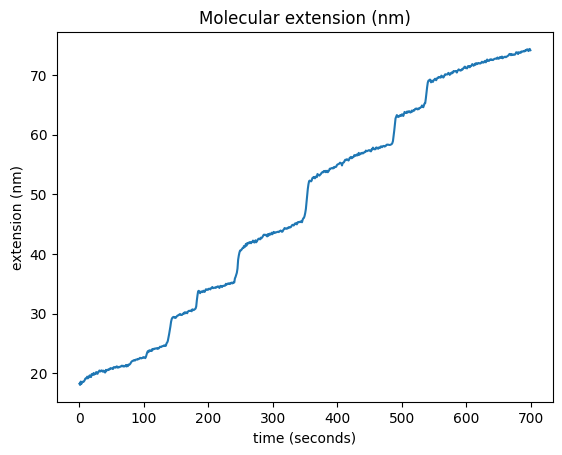

In [16]:
# plot the extension profile

plt.plot( extension)
plt.title('Molecular extension (nm)')
plt.ylabel('extension (nm)')
plt.xlabel('time (seconds)')

### Plot the force versus the molecular extension

Text(0, 0.5, 'force (pN)')

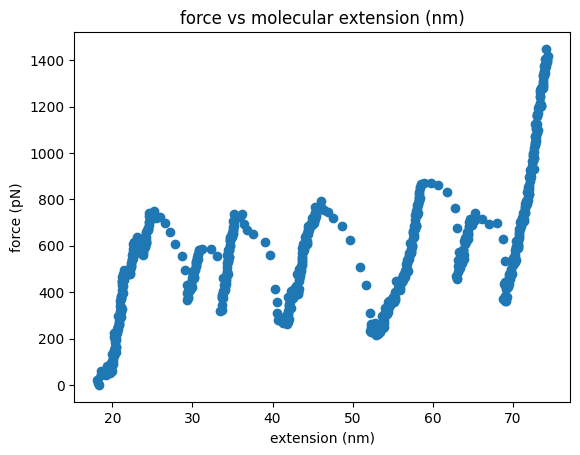

In [17]:
plt.scatter( extension, force[:len(extension)])
plt.title('force vs molecular extension (nm)')
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')

### 5) Calculate the correlations





In [18]:
def calculate_distance(coord1, coord2):
    """
    Parameters
    ----------
    coord1 : numpy matrix of  x , y , z coordinates of first residue
        DESCRIPTION.
    coord2 : numpy matrix of coordinates of second residue
        DESCRIPTION.

    Returns
    -------
    TYPE
        matrix numpy of eucleadian distance between the two residues

    """
    #Eucleadian distance between two coordinates of two atoms
    return np.linalg.norm(coord1 - coord2)

def calculate_center_of_mass_trajectory(pdb_path, dcd_path, residue_ids):
    # Load the protein structure from the PDB file
    structure = parsePDB(pdb_path)

    # Select only PROTEIN atoms, NO IONS, NO WATER, and calcium
    protein = structure.select('protein or resname CAL')

    residue_names = []
    for atom in protein:
        residue_names.append(atom.getResname())

    # Load the trajectory from the DCD file
    trajectory = parseDCD(dcd_path)

    com_trajectories = {}

    for residue_id in residue_ids:
        residue = protein.select(f'resid {residue_id} or resname CAL')
        atom_indices = residue.getIndices()

        # Calculate the mass of each atom
        masses = np.array([atom.getMass() for atom in residue])

        com_trajectory = []

        for frame in trajectory:
            coords = frame.getCoords()
            residue_coords = coords[atom_indices]

            # Calculate the mass-weighted center of mass of the residue
            com = np.sum(residue_coords * masses[:, np.newaxis], axis=0) / np.sum(masses)
            com_trajectory.append(com)

        com_trajectories[residue_id] = com_trajectory

    return com_trajectories, residue_names

def calculate_distances_between_residues(pdb_path, dcd_path, residue_ids, start_frame, end_frame):
    """
    Parameters
    ----------
    pdb_path : str
        path to pdb
    dcd_path :  str
        path to dcd
    residue_ids : list
        list of residue ids
    start_frame : int
        index of frame at which you want to start calculation
    end_frame : int
        index of frame at which you want to end calculation

    Returns
    -------
    distances : dctionary of distances between pairs of residues
        key is tuple: pair of residue
        value is distance in angstrom
    residue_names : list
        list of residue names

    """
    # Calculate the center of mass trajectory for each residue
    com_trajectories, residue_names = calculate_center_of_mass_trajectory(pdb_path, dcd_path, residue_ids)

    # Generate pairs of residues
    residue_pairs = []
    for i in range(len(residue_ids)):
        for j in range(i+1, len(residue_ids)):
            #store pairs in list: residue i and residue i-1
            residue_pairs.append((residue_ids[i], residue_ids[j]))
    #init dict of distances
    distances = {}
    # loop over resdiue pairs
    for residue_pair in residue_pairs:
        # get number (id) of res1 and res2 from tuple
        res1, res2 = residue_pair
        # get center of mass of residue 1
        com_trajectory1 = com_trajectories[res1]
        #get center of mass of residue 2
        com_trajectory2 = com_trajectories[res2]

        # Calculate the distance between center of mass for each frame within the specified range
        distance_trajectory = []
        # loop over selected frames
        for frame_num in range(start_frame, end_frame):
            #get center of mass at that specefic frame for both residues
            com1 = com_trajectory1[frame_num]
            com2 = com_trajectory2[frame_num]
            #calculate eucleadian distance between the two centers of mass
            distance = calculate_distance(com1, com2)
            #store the found distance at each frame in distance_trajectory list
            distance_trajectory.append(distance)

        #fill the dict in the following way: key is pair of residues (tuple) and the distances at each frame for that pair
        distances[residue_pair] = distance_trajectory

    return distances, residue_names



def calculate_correlations(distances, force_values, threshold):
    """
    Calculate correlations between distances and force values for pairs of residues that exceed the threshold.

    Parameters:
    distances (dictionary): Dictionary where keys are residue pairs and values are distance trajectories.
    force_values (numpy array): Array of shape (n_frames,) representing the force values.
    threshold (float): Threshold value to filter the pairs of residues based on the distance that seperates them (threshold is distnace).

    Returns:
    correlations (dictionary): Dictionary where keys are residue pairs that exceed the threshold and values are the correlations between distances and force values.
    """
    #init dict of correlations
    correlations = {}
    #loop over distances  dict  : pairs of residues are tuples and value are distances
    for pair, distance_trajectory in distances.items():
        distance_trajectory = np.array(distance_trajectory)  #  distance trajectory to NumPy array
        #discard distances that  do not respect threshold
        if np.any(distance_trajectory < threshold):
                        #vector of force that we extract from log contains all the data
            #we want the vectors to have the same size before correlation;
            min_length = min(len(distance_trajectory), len(force_values))
            distance_trajectory = distance_trajectory[:min_length]
            force_values_residue = force_values[:min_length]

            #calculate correlations using np.corrcoef
            # The function will return a symmetric matrix of correlation coefficients,
            #with the diagonal elements being 1 (since each variable is perfectly correlated with itself).
            correlation = np.corrcoef(distance_trajectory, force_values_residue)[0, 1] #[0,1 ] to avoid getting the 1 of perfect correlation of variable with itself
            correlations[pair] = correlation
    return correlations


In [19]:
# the first and last residue IDs are extracted from the PDB
Nter, Cter, structure= e2e_PDB(pdb_file)

# default is correlation from end to end
#you can modify the two variables below according to your needs
residue_start= Nter
residue_end= Cter
# specify the range of frames to calculate the correlation (two variables below can be modified)
frame_start= 1
frame_end = 20

#specify threshold distance between pairs of residues (default is 13 angstroms)
#which means that pairs of residues separated by a distance above 13 angtroms will not be considered
cutoff= 13  #you can modify according to your needs


#first we need to calculate the eucleadian distances between pairs of residues:
distances ,residue_names = calculate_distances_between_residues(pdb_file, dcd_file, list(range(int(residue_start), int(residue_end))),
                                                                                         frame_start, frame_end)

### Do not modify the code below
#n here represents how many full windows of length frame_end can fit into the force array.
n =  len(force) // frame_end
#The code below creates a window of length n with each element set to 1/n.
#This window will be used for smoothing the force array.
#The np.ones(n,) creates an array of ones with length n, and (1 / n) scales each element to 1/n.
# ==>  This effectively creates a simple moving average window.
window = ( 1/ n) * np.ones(n,)
#    This convolves the force array with the window. Convolution is a mathematical operation used here for smoothing the force array.
#    The mode='valid' parameter ensures that the convolution is only computed where the window fully overlaps with the force array ==> avoids boundary effects.
#    The [::n] part subsamples the convolved result by taking every n-th element ==> reduces the number of data points, effectively downsampling the smoothed force array.
frc= np.convolve(force, window, mode='valid')[::n]
correlation = calculate_correlations(distances, frc, cutoff)

@> 6877 atoms and 1 coordinate set(s) were parsed in 0.29s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.29s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.39s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.39s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.25 seconds.
INFO:.prody:DCD file was parsed in 0.25 seconds.
@> 55.14 MB parsed at input rate 222.35 MB/s.
INFO:.prody:55.14 MB parsed at input rate 222.35 MB/s.
@> 700 coordinate sets parsed at input rate 2822 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 2822 frame/s.


In [20]:
print(correlation)
# prints a dictionary where the pairs of residues are between () as values and keys are the coeff of correlation

{(1, 2): 0.13619561602423083, (1, 3): 0.3005655535064017, (1, 4): 0.15928785661166164, (1, 5): 0.19124422886815004, (1, 7): 0.04793834059236364, (1, 20): 0.07804382028299323, (1, 21): 0.14317188912230908, (1, 22): 0.14214953355782353, (1, 23): -0.2366585185609794, (1, 24): -0.274445774394047, (1, 25): -0.22770881705890708, (1, 26): -0.3195238894811177, (1, 28): -0.25437526550450135, (1, 29): -0.029973263516771594, (1, 30): -0.2112748595827977, (1, 31): 0.019696712843999514, (1, 32): 0.11332466378365996, (1, 48): -0.026849803364836267, (1, 64): 0.3121505324697577, (1, 65): 0.13428976119229472, (1, 66): 0.10962209505632035, (1, 67): 0.052291676730288256, (1, 68): -0.11238887262629442, (1, 69): -0.11219286973776649, (1, 70): -0.08443173975849484, (1, 71): -0.16908231460662676, (1, 72): -0.15695382265645796, (1, 73): -0.021026707395805706, (1, 74): 0.012570713949439516, (1, 75): 0.01403540232331423, (1, 76): 0.15341289149181686, (1, 77): -0.10817376260357454, (2, 3): 0.45671131643873003, (

#### Plot the correlations matrix as a heatmap

In [21]:
def plot_correlation_heatmap(correlations):
    # Extract the residue indices from the correlations dictionary
    residues = sorted(list(set([residue for pair in correlations.keys() for residue in pair])))

    # Create an empty correlation matrix
    correlation_matrix = np.zeros((len(residues), len(residues)))

    # Fill the correlation matrix with the correlation coefficients
    for pair, correlation in correlations.items():
        residue1, residue2 = pair
        idx1 = residues.index(residue1)
        idx2 = residues.index(residue2)
        correlation_matrix[idx1, idx2] = correlation
        correlation_matrix[idx2, idx1] = correlation
    return correlation_matrix, residues


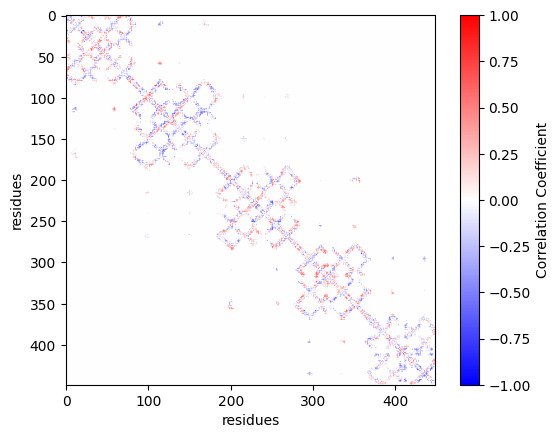

In [22]:
correlation_matrix, residues= plot_correlation_heatmap(correlation)
heatmap=plt.imshow(correlation_matrix,  cmap='bwr', vmin=-1, vmax=1)
plt.xlabel('residues')
plt.ylabel('residues')
plt.colorbar(heatmap, label='Correlation Coefficient')


In [23]:
#export the correlations in a CSV file
df_corr = pd.DataFrame(correlation_matrix)
df_corr.index = df_corr.index + 1
df_corr.columns = residues
df_corr.to_csv('correlations.csv')
print("CSV file saved successfully! ")

CSV file saved successfully! 


### Download the correlation map as a GIF or Video

The correlation map will be plotted every N frame

In [24]:
import imageio
import os
def generate_animation(pdb_file, dcd_file, residue_start, residue_end, start_frame, end_frame,  force, cutoff,output_file_name, N, output_type='gif'):
    """
    This function generates an animation of the correlation map either in MP4 or GIF format
    the ouput of correlation maps is every N frames
    pdb_file: str
        pdb file
    dcd_file: str
        trajectory file from NAMD simulations
    residue_start:  str
        tells from which residue to start the calculation
    residue_end: str
        tells at which residue to stop
    start_frame: int
        tells at which frame start
    end_frame: int
        tells at which frame to stop
    force: list
        list containing force values
    cuttoff: int
        cutoff distance (less than this distance threshold; the correlations are not calculated)
    outputfile_name: str
        name of output file
    N: int
        number of windows, every N window the correlation map is calculated
    outputype: str
        if GIF or MP4
    """
    frames = []

    for index in np.arange(start_frame, end_frame, N):
        frame_start = index
        frame_end = index + N
        print(f"Processing frames {frame_start} to {frame_end}")

        distances, residue_names = calculate_distances_between_residues(pdb_file, dcd_file, list(range(int(residue_start), int(residue_end))), frame_start, frame_end)
        n = len(force) // frame_end
        window = (1 / n) * np.ones(n)
        frc = np.convolve(force, window, mode='valid')[::n]
        correlation = calculate_correlations(distances, frc, cutoff)

        correlation_matrix, residues = plot_correlation_heatmap(correlation)

        plt.imshow(correlation_matrix, cmap='bwr', vmin=-1, vmax=1)
        plt.xlabel('Residues')
        plt.ylabel('Residues')
        plt.title(f"Correlation Heatmap: Frames {frame_start} to {frame_end}")
        filename = f"{str(index).zfill(4)}.png"
        plt.savefig(filename)
        plt.close()
        frames.append(filename)

    if output_type == 'gif':
        with imageio.get_writer(output_file_name+'.gif', mode='I', duration=end_frame) as writer:
            for frame in frames:
                image = imageio.imread(frame)
                writer.append_data(image)
    elif output_type == 'video':
        with imageio.get_writer(output_file_name+'.mp4') as writer:
            for frame in frames:
                writer.append_data(imageio.imread(frame))

    else:
        print("Invalid output type. Please choose 'gif' or 'video'.")

    for frame in frames:
        os.remove(frame)
    writer.close()
    print(f"Animation saved as correlation_animation.{output_type}")


In [25]:
#specify the output file name here:
output_file_name="correlation_animation"
#what format would you like "gif" or "video" ?
download_as= "gif"
#generate correlation heatmap every N frame
N=20

#starting from frame:
start_frame=0
#to
end_frame=700

## here is the function (DO NOT MODIFY THIS):
generate_animation(pdb_file, dcd_file, residue_start, residue_end, start_frame, end_frame, force, cutoff, output_file_name, N, download_as)

@> 6877 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.09s.


Processing frames 0 to 20


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 637.56 MB/s.
INFO:.prody:55.14 MB parsed at input rate 637.56 MB/s.
@> 700 coordinate sets parsed at input rate 8093 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8093 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 20 to 40


@> DCD file was parsed in 0.18 seconds.
INFO:.prody:DCD file was parsed in 0.18 seconds.
@> 55.14 MB parsed at input rate 312.27 MB/s.
INFO:.prody:55.14 MB parsed at input rate 312.27 MB/s.
@> 700 coordinate sets parsed at input rate 3963 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 3963 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 40 to 60


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 688.36 MB/s.
INFO:.prody:55.14 MB parsed at input rate 688.36 MB/s.
@> 700 coordinate sets parsed at input rate 8738 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8738 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.


Processing frames 60 to 80


@> 55.14 MB parsed at input rate 714.93 MB/s.
INFO:.prody:55.14 MB parsed at input rate 714.93 MB/s.
@> 700 coordinate sets parsed at input rate 9075 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9075 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 80 to 100


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 681.89 MB/s.
INFO:.prody:55.14 MB parsed at input rate 681.89 MB/s.
@> 700 coordinate sets parsed at input rate 8655 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8655 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


Processing frames 100 to 120


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.12 seconds.
INFO:.prody:DCD file was parsed in 0.12 seconds.
@> 55.14 MB parsed at input rate 448.02 MB/s.
INFO:.prody:55.14 MB parsed at input rate 448.02 MB/s.
@> 700 coordinate sets parsed at input rate 5687 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 5687 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 120 to 140


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 722.62 MB/s.
INFO:.prody:55.14 MB parsed at input rate 722.62 MB/s.
@> 700 coordinate sets parsed at input rate 9172 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9172 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 140 to 160


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 709.23 MB/s.
INFO:.prody:55.14 MB parsed at input rate 709.23 MB/s.
@> 700 coordinate sets parsed at input rate 9002 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9002 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 756.57 MB/s.
INFO:.prody:55.14 MB parsed at input rate 756.57 MB/s.
@> 700 coordinate sets parsed at input rate 9603 frame/s.


Processing frames 160 to 180


INFO:.prody:700 coordinate sets parsed at input rate 9603 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 180 to 200


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 625.23 MB/s.
INFO:.prody:55.14 MB parsed at input rate 625.23 MB/s.
@> 700 coordinate sets parsed at input rate 7936 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7936 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.14s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.14s.


Processing frames 200 to 220


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 598.62 MB/s.
INFO:.prody:55.14 MB parsed at input rate 598.62 MB/s.
@> 700 coordinate sets parsed at input rate 7598 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7598 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 220 to 240


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 717.22 MB/s.
INFO:.prody:55.14 MB parsed at input rate 717.22 MB/s.
@> 700 coordinate sets parsed at input rate 9104 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9104 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.


Processing frames 240 to 260


@> 55.14 MB parsed at input rate 721.64 MB/s.
INFO:.prody:55.14 MB parsed at input rate 721.64 MB/s.
@> 700 coordinate sets parsed at input rate 9160 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9160 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 260 to 280


@> DCD file was parsed in 0.18 seconds.
INFO:.prody:DCD file was parsed in 0.18 seconds.
@> 55.14 MB parsed at input rate 302.14 MB/s.
INFO:.prody:55.14 MB parsed at input rate 302.14 MB/s.
@> 700 coordinate sets parsed at input rate 3835 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 3835 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 770.75 MB/s.
INFO:.prody:55.14 MB parsed at input rate 770.75 MB/s.


Processing frames 280 to 300


@> 700 coordinate sets parsed at input rate 9783 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9783 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 300 to 320


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 531.92 MB/s.
INFO:.prody:55.14 MB parsed at input rate 531.92 MB/s.
@> 700 coordinate sets parsed at input rate 6752 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6752 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 320 to 340


@> DCD file was parsed in 0.12 seconds.
INFO:.prody:DCD file was parsed in 0.12 seconds.
@> 55.14 MB parsed at input rate 477.63 MB/s.
INFO:.prody:55.14 MB parsed at input rate 477.63 MB/s.
@> 700 coordinate sets parsed at input rate 6062 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6062 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 340 to 360


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 691.06 MB/s.
INFO:.prody:55.14 MB parsed at input rate 691.06 MB/s.
@> 700 coordinate sets parsed at input rate 8772 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8772 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 360 to 380


@> DCD file was parsed in 0.12 seconds.
INFO:.prody:DCD file was parsed in 0.12 seconds.
@> 55.14 MB parsed at input rate 469.13 MB/s.
INFO:.prody:55.14 MB parsed at input rate 469.13 MB/s.
@> 700 coordinate sets parsed at input rate 5955 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 5955 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 380 to 400


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 681.63 MB/s.
INFO:.prody:55.14 MB parsed at input rate 681.63 MB/s.
@> 700 coordinate sets parsed at input rate 8652 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8652 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


Processing frames 400 to 420


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.11 seconds.
INFO:.prody:DCD file was parsed in 0.11 seconds.
@> 55.14 MB parsed at input rate 483.80 MB/s.
INFO:.prody:55.14 MB parsed at input rate 483.80 MB/s.
@> 700 coordinate sets parsed at input rate 6141 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6141 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 420 to 440


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 576.96 MB/s.
INFO:.prody:55.14 MB parsed at input rate 576.96 MB/s.
@> 700 coordinate sets parsed at input rate 7323 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7323 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 440 to 460


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 691.06 MB/s.
INFO:.prody:55.14 MB parsed at input rate 691.06 MB/s.
@> 700 coordinate sets parsed at input rate 8772 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8772 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 460 to 480


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 718.55 MB/s.
INFO:.prody:55.14 MB parsed at input rate 718.55 MB/s.
@> 700 coordinate sets parsed at input rate 9121 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9121 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.13s.


Processing frames 480 to 500


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 603.40 MB/s.
INFO:.prody:55.14 MB parsed at input rate 603.40 MB/s.
@> 700 coordinate sets parsed at input rate 7659 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7659 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 500 to 520


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 655.75 MB/s.
INFO:.prody:55.14 MB parsed at input rate 655.75 MB/s.
@> 700 coordinate sets parsed at input rate 8324 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8324 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 520 to 540


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 718.86 MB/s.
INFO:.prody:55.14 MB parsed at input rate 718.86 MB/s.
@> 700 coordinate sets parsed at input rate 9125 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9125 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 540 to 560


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 621.69 MB/s.
INFO:.prody:55.14 MB parsed at input rate 621.69 MB/s.
@> 700 coordinate sets parsed at input rate 7891 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7891 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


Processing frames 560 to 580


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 549.18 MB/s.
INFO:.prody:55.14 MB parsed at input rate 549.18 MB/s.
@> 700 coordinate sets parsed at input rate 6971 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6971 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 580 to 600


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 658.16 MB/s.
INFO:.prody:55.14 MB parsed at input rate 658.16 MB/s.
@> 700 coordinate sets parsed at input rate 8354 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8354 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 600 to 620


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 716.43 MB/s.
INFO:.prody:55.14 MB parsed at input rate 716.43 MB/s.
@> 700 coordinate sets parsed at input rate 9094 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9094 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 620 to 640


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 708.46 MB/s.
INFO:.prody:55.14 MB parsed at input rate 708.46 MB/s.
@> 700 coordinate sets parsed at input rate 8993 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8993 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 640 to 660


@> DCD file was parsed in 0.15 seconds.
INFO:.prody:DCD file was parsed in 0.15 seconds.
@> 55.14 MB parsed at input rate 376.09 MB/s.
INFO:.prody:55.14 MB parsed at input rate 376.09 MB/s.
@> 700 coordinate sets parsed at input rate 4774 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 4774 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 660 to 680


@> DCD file was parsed in 0.12 seconds.
INFO:.prody:DCD file was parsed in 0.12 seconds.
@> 55.14 MB parsed at input rate 457.06 MB/s.
INFO:.prody:55.14 MB parsed at input rate 457.06 MB/s.
@> 700 coordinate sets parsed at input rate 5801 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 5801 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


Processing frames 680 to 700


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 723.74 MB/s.
INFO:.prody:55.14 MB parsed at input rate 723.74 MB/s.
@> 700 coordinate sets parsed at input rate 9187 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9187 frame/s.
<ipython-input-24-d1eaec3a5f35>:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


Animation saved as correlation_animation.gif


###The generated GIF correlation map is accessible here:

https://drive.google.com/drive/folders/19Vospz-MLBzLDr4teTgJK_gUjeVPFERq?usp=sharing

###Track the Pearson coefficient along frames for a specific pair of residues

@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 0 to 20


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 529.61 MB/s.
INFO:.prody:55.14 MB parsed at input rate 529.61 MB/s.
@> 700 coordinate sets parsed at input rate 6722 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6722 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.061554072124293854
Processing frames 20 to 40


@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 760.28 MB/s.
INFO:.prody:55.14 MB parsed at input rate 760.28 MB/s.
@> 700 coordinate sets parsed at input rate 9651 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9651 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


-0.469952075597772
Processing frames 40 to 60


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 593.89 MB/s.
INFO:.prody:55.14 MB parsed at input rate 593.89 MB/s.
@> 700 coordinate sets parsed at input rate 7538 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7538 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


-0.1912477185962046
Processing frames 60 to 80


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 731.20 MB/s.
INFO:.prody:55.14 MB parsed at input rate 731.20 MB/s.
@> 700 coordinate sets parsed at input rate 9281 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9281 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.017969010446801572
Processing frames 80 to 100


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 599.13 MB/s.
INFO:.prody:55.14 MB parsed at input rate 599.13 MB/s.
@> 700 coordinate sets parsed at input rate 7605 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7605 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.23577770776720383
Processing frames 100 to 120


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 711.50 MB/s.
INFO:.prody:55.14 MB parsed at input rate 711.50 MB/s.
@> 700 coordinate sets parsed at input rate 9031 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9031 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


-0.30266797443843163
Processing frames 120 to 140


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 598.12 MB/s.
INFO:.prody:55.14 MB parsed at input rate 598.12 MB/s.
@> 700 coordinate sets parsed at input rate 7592 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7592 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


0.14994897653307837
Processing frames 140 to 160


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 711.97 MB/s.
INFO:.prody:55.14 MB parsed at input rate 711.97 MB/s.
@> 700 coordinate sets parsed at input rate 9037 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9037 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.5364505770343844
Processing frames 160 to 180


@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 745.03 MB/s.
INFO:.prody:55.14 MB parsed at input rate 745.03 MB/s.
@> 700 coordinate sets parsed at input rate 9457 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9457 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.3791268912785001
Processing frames 180 to 200


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 704.73 MB/s.
INFO:.prody:55.14 MB parsed at input rate 704.73 MB/s.
@> 700 coordinate sets parsed at input rate 8945 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8945 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.


0.43595518963923297
Processing frames 200 to 220


@> 55.14 MB parsed at input rate 734.71 MB/s.
INFO:.prody:55.14 MB parsed at input rate 734.71 MB/s.
@> 700 coordinate sets parsed at input rate 9326 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9326 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


-0.20792084772872513
Processing frames 220 to 240


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 714.46 MB/s.
INFO:.prody:55.14 MB parsed at input rate 714.46 MB/s.
@> 700 coordinate sets parsed at input rate 9069 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9069 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.5234424949564882
Processing frames 240 to 260


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 703.25 MB/s.
INFO:.prody:55.14 MB parsed at input rate 703.25 MB/s.
@> 700 coordinate sets parsed at input rate 8927 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8927 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.04285245633163357
Processing frames 260 to 280


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 621.14 MB/s.
INFO:.prody:55.14 MB parsed at input rate 621.14 MB/s.
@> 700 coordinate sets parsed at input rate 7884 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7884 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.13s.


0.09267292519174224
Processing frames 280 to 300


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.14 seconds.
INFO:.prody:DCD file was parsed in 0.14 seconds.
@> 55.14 MB parsed at input rate 406.88 MB/s.
INFO:.prody:55.14 MB parsed at input rate 406.88 MB/s.
@> 700 coordinate sets parsed at input rate 5164 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 5164 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.06s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.21439280852949377
Processing frames 300 to 320


@> DCD file was parsed in 0.11 seconds.
INFO:.prody:DCD file was parsed in 0.11 seconds.
@> 55.14 MB parsed at input rate 519.30 MB/s.
INFO:.prody:55.14 MB parsed at input rate 519.30 MB/s.
@> 700 coordinate sets parsed at input rate 6592 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6592 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.13723534473460175
Processing frames 320 to 340


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 573.95 MB/s.
INFO:.prody:55.14 MB parsed at input rate 573.95 MB/s.
@> 700 coordinate sets parsed at input rate 7285 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7285 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


-0.2551453198265662
Processing frames 340 to 360


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 652.09 MB/s.
INFO:.prody:55.14 MB parsed at input rate 652.09 MB/s.
@> 700 coordinate sets parsed at input rate 8277 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8277 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.6656165049307454
Processing frames 360 to 380


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 617.19 MB/s.
INFO:.prody:55.14 MB parsed at input rate 617.19 MB/s.
@> 700 coordinate sets parsed at input rate 7834 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7834 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 380 to 400


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 582.52 MB/s.
INFO:.prody:55.14 MB parsed at input rate 582.52 MB/s.
@> 700 coordinate sets parsed at input rate 7394 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7394 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 400 to 420


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 630.43 MB/s.
INFO:.prody:55.14 MB parsed at input rate 630.43 MB/s.
@> 700 coordinate sets parsed at input rate 8002 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8002 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


0.0
Processing frames 420 to 440


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 607.27 MB/s.
INFO:.prody:55.14 MB parsed at input rate 607.27 MB/s.
@> 700 coordinate sets parsed at input rate 7708 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7708 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 440 to 460


@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 639.64 MB/s.
INFO:.prody:55.14 MB parsed at input rate 639.64 MB/s.
@> 700 coordinate sets parsed at input rate 8119 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8119 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 460 to 480


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 732.18 MB/s.
INFO:.prody:55.14 MB parsed at input rate 732.18 MB/s.
@> 700 coordinate sets parsed at input rate 9294 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9294 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


0.0
Processing frames 480 to 500


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 727.97 MB/s.
INFO:.prody:55.14 MB parsed at input rate 727.97 MB/s.
@> 700 coordinate sets parsed at input rate 9240 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9240 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 500 to 520


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 675.81 MB/s.
INFO:.prody:55.14 MB parsed at input rate 675.81 MB/s.
@> 700 coordinate sets parsed at input rate 8578 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8578 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 520 to 540


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 713.66 MB/s.
INFO:.prody:55.14 MB parsed at input rate 713.66 MB/s.
@> 700 coordinate sets parsed at input rate 9059 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9059 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 540 to 560


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 654.54 MB/s.
INFO:.prody:55.14 MB parsed at input rate 654.54 MB/s.
@> 700 coordinate sets parsed at input rate 8308 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8308 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.13s.


0.0
Processing frames 560 to 580


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.11 seconds.
INFO:.prody:DCD file was parsed in 0.11 seconds.
@> 55.14 MB parsed at input rate 496.34 MB/s.
INFO:.prody:55.14 MB parsed at input rate 496.34 MB/s.
@> 700 coordinate sets parsed at input rate 6300 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6300 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 580 to 600


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 692.32 MB/s.
INFO:.prody:55.14 MB parsed at input rate 692.32 MB/s.
@> 700 coordinate sets parsed at input rate 8788 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8788 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.08 seconds.


0.0
Processing frames 600 to 620


INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 732.37 MB/s.
INFO:.prody:55.14 MB parsed at input rate 732.37 MB/s.
@> 700 coordinate sets parsed at input rate 9296 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9296 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 620 to 640


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 694.05 MB/s.
INFO:.prody:55.14 MB parsed at input rate 694.05 MB/s.
@> 700 coordinate sets parsed at input rate 8810 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8810 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.14s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.14s.


0.0
Processing frames 640 to 660


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 545.09 MB/s.
INFO:.prody:55.14 MB parsed at input rate 545.09 MB/s.
@> 700 coordinate sets parsed at input rate 6919 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6919 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 660 to 680


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 689.59 MB/s.
INFO:.prody:55.14 MB parsed at input rate 689.59 MB/s.
@> 700 coordinate sets parsed at input rate 8753 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8753 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


0.0
Processing frames 680 to 700


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 719.16 MB/s.
INFO:.prody:55.14 MB parsed at input rate 719.16 MB/s.
@> 700 coordinate sets parsed at input rate 9128 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9128 frame/s.


0.0
[-0.061554072124293854, -0.469952075597772, -0.1912477185962046, -0.017969010446801572, -0.23577770776720383, -0.30266797443843163, 0.14994897653307837, 0.5364505770343844, -0.3791268912785001, 0.43595518963923297, -0.20792084772872513, 0.5234424949564882, -0.04285245633163357, 0.09267292519174224, -0.21439280852949377, 0.13723534473460175, -0.2551453198265662, 0.6656165049307454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680]


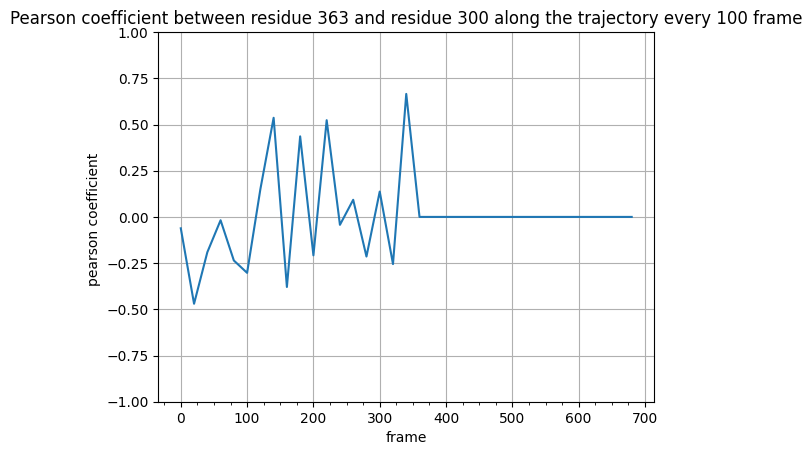

In [26]:
residue_ids= list(range(1, 450))
frame_start=0
frame_end=700
N=20
cutoff= 13

frames_list= list(range( frame_start, frame_end, N))
coeff_pairs_res= []


for index in np.arange(frame_start, frame_end, N):
    frame_start = index
    frame_end = index + N
    print(f"Processing frames {frame_start} to {frame_end}")
    distances, residue_names = calculate_distances_between_residues(pdb_file, dcd_file, residue_ids, frame_start, frame_end)
    n = len(df["F[pN]"]) //  frame_end
    window = (1 / n) * np.ones(n)
    frc = np.convolve(df["F[pN]"], window, mode='valid')[::n]
    correlation = calculate_correlations(distances, frc, cutoff)


    correlation_matrix, residues = plot_correlation_heatmap(correlation)
  #  print(correlation_matrix)



    df_corr = pd.DataFrame(correlation_matrix)
    df_corr.index = residues
    df_corr.columns = residues
   # df_corr.to_csv("data"+str(index)+".csv")
    print(df_corr[363][300])
    coeff_pairs_res.append(df_corr[363][300])

print(coeff_pairs_res)
print(frames_list)



import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots()

minor_locator = AutoMinorLocator(4)
ax.xaxis.set_minor_locator(minor_locator)


ax.plot( frames_list, coeff_pairs_res)
ax.grid()
plt.ylim(-1,1)
#plt.minorticks_on()
plt.xlabel("frame")
plt.ylabel("pearson coefficient ")
plt.title("Pearson coefficient between residue 363 and residue 300 along the trajectory every 100 frame")
plt.show()



### Calculation of work of each pair of residue along frames (dot product of distance between pairs of residues and force vector)

In [ ]:
def calculate_work(pdb_path, dcd_path, force_vector, start_frame, end_frame, residue_ids):
    """
    Calculate pairwise distances (independently for x, y, z coordinates) between all residues,
    multiply each distance by the respective force component, and calculate the work over the trajectory.

    Parameters:
    pdb_path (str): Path to the PDB file.
    dcd_path (str): Path to the DCD file.
    force_vector (numpy array): Force vector (Fx, Fy, Fz) to multiply with distances.
    start_frame (int): The starting frame for analysis.
    end_frame (int): The ending frame for analysis.

    Returns:
    work_per_pair (dict): Dictionary where keys are pairs of residue IDs and values are the total work for each pair.
    """
    # load the trajectory and calculate the center of mass for each residue
    com_trajectories, residue_names = calculate_center_of_mass_trajectory(pdb_path, dcd_path, residue_ids)
    all_residue_ids = list(com_trajectories.keys())

    # initialize storage for force contribution calculation
    work_per_pair = {}

    #loop through all pairs of residues
    for i in range(len(all_residue_ids)):
        for j in range(i + 1, len(all_residue_ids)):  # Only compute each pair once (i,j)
            residue1 = all_residue_ids[i]
            residue2 = all_residue_ids[j]

            # Get the center of mass trajectory of both residues
            com_trajectory1 = com_trajectories[residue1]
            com_trajectory2 = com_trajectories[residue2]

            # Initialize
            total_work = 0.0

            # loop through frames and calculate distances and force contribution
            for frame_num in range(start_frame, end_frame):
                com1 = com_trajectory1[frame_num]
                com2 = com_trajectory2[frame_num]

                # Calculate the distance between the two residues for each coordinate
                dx = com1[0] - com2[0]  # Distance in x
                dy = com1[1] - com2[1]  # Distance in y
                dz = com1[2] - com2[2]  # Distance in z

                # Create the distance vector
                distance_vector = np.array([dx, dy, dz])

                # Calculate the work using dot product between distance vector and force vector
                work_frame = np.dot(distance_vector, force_vector)

                # Accumulate work over frames
                total_work += work_frame

            work_per_pair[(residue1, residue2)] = total_work


    return work_per_pair


def plot_work_heatmap(work_per_pair, residue_ids):
    """
    Plot a symmetric heatmap of force contributions between residue pairs.

    Parameters:
    force_contribution_per_pair (dict): Dictionary where keys are pairs of residue IDs and values are the force contributions.
    residue_ids (list): List of residue IDs to be used for labeling the heatmap.
    """
    # Initialize a square matrix for the heatmap
    n_residues = len(residue_ids)
    heatmap_data = np.zeros((n_residues, n_residues))

    # Fill the matrix with force contributions symmetrically
    for (residue1, residue2), contribution in work_per_pair.items():
        if residue1 in residue_ids and residue2 in residue_ids:
            idx1 = residue_ids.index(residue1)
            idx2 = residue_ids.index(residue2)
            # Assign the contribution to both (i, j) and (j, i) to ensure symmetry
            heatmap_data[idx1, idx2] = contribution
            heatmap_data[idx2, idx1] = contribution  # Make the matrix symmetric
    return heatmap_data

@> 6877 atoms and 1 coordinate set(s) were parsed in 0.19s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.19s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.13 seconds.
INFO:.prody:DCD file was parsed in 0.13 seconds.
@> 55.14 MB parsed at input rate 427.54 MB/s.
INFO:.prody:55.14 MB parsed at input rate 427.54 MB/s.
@> 700 coordinate sets parsed at input rate 5427 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 5427 frame/s.


Text(0.5, 1.0, 'work Heatmap: Frames 0 to 200')

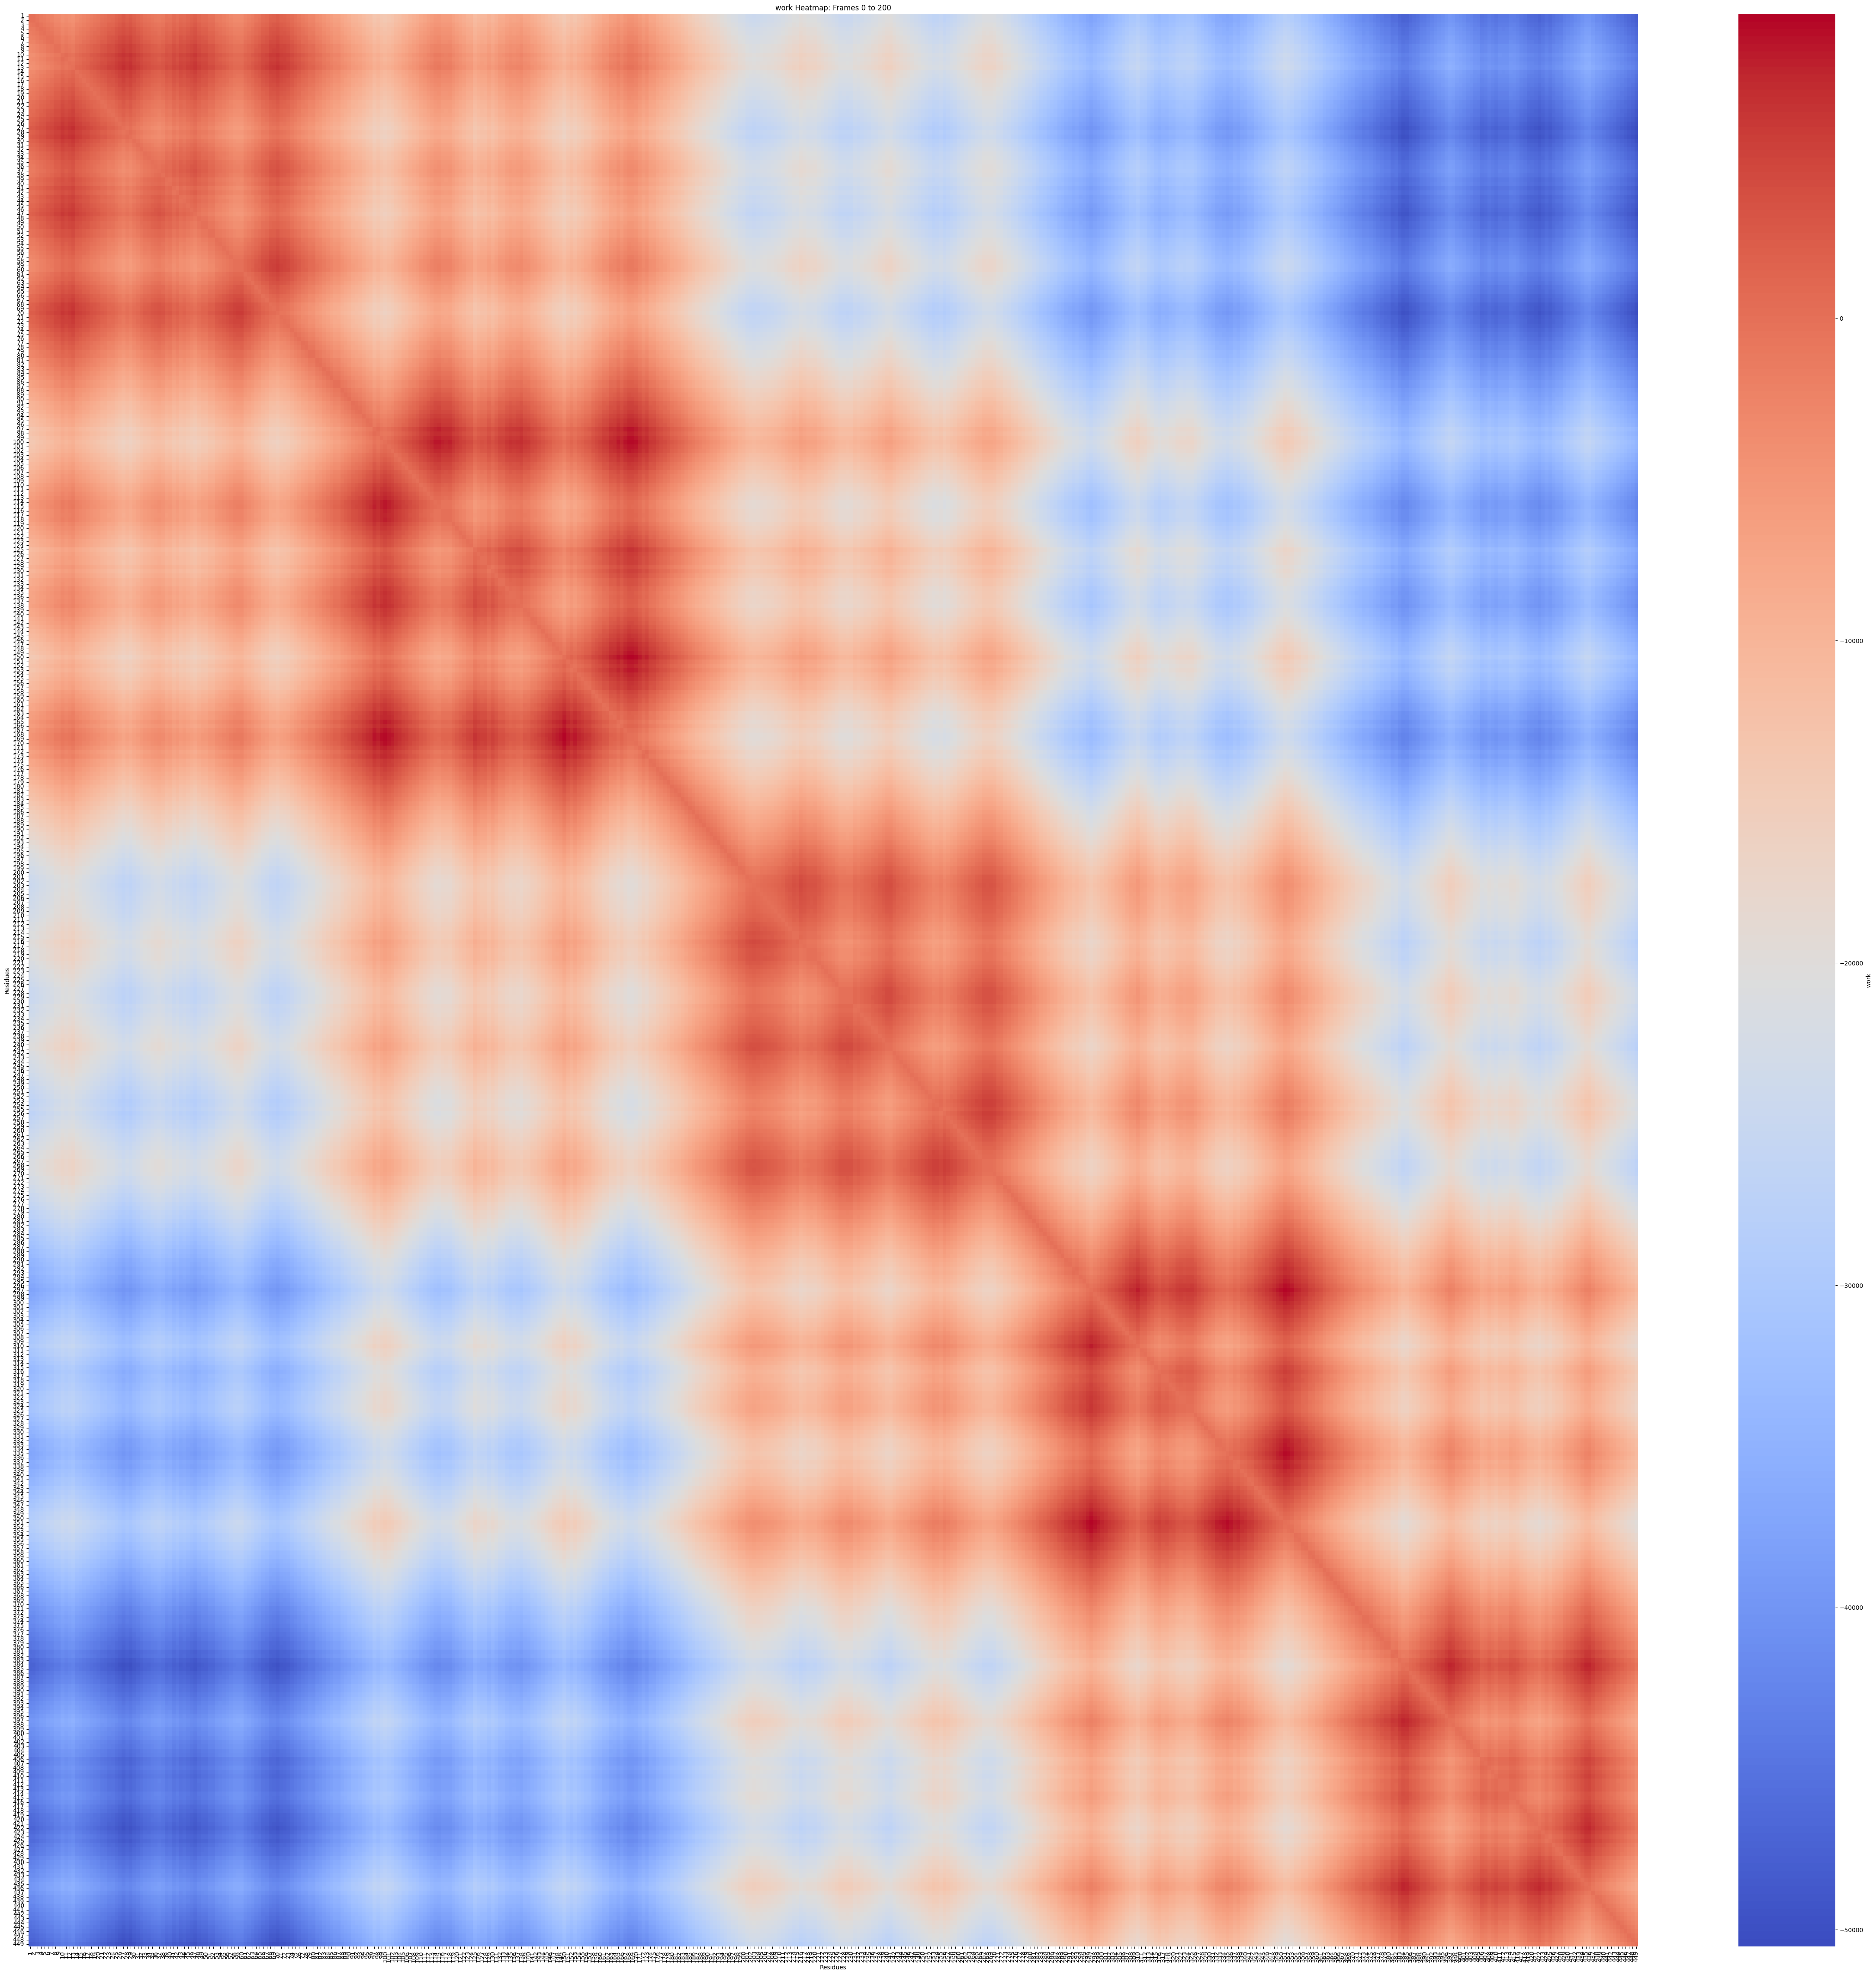

In [32]:
import seaborn as sns
force_vector= np.array(df['direction'][:3])
first_residue=1
last_residue=450
residue_ids= list(range(first_residue, last_residue))
frame_start=0
frame_end= 200
work_per_pair = calculate_work(pdb_file, dcd_file, force_vector, frame_start, frame_end, residue_ids)
heatmap_data= plot_work_heatmap(work_per_pair, residue_ids)


plt.figure(figsize=(60,58))
sns.heatmap(heatmap_data,  cmap='coolwarm',
       xticklabels=residue_ids, yticklabels=residue_ids,
        cbar_kws={'label': 'work'})
plt.xlabel('Residues')
plt.ylabel('Residues')
plt.title(f"work Heatmap: Frames {frame_start} to {frame_end}")

#### Dynamic heatmap generation for the 4th domain of ICAM1

The work between each residue pair is calculated every 50 frame

In [33]:
start_frame=0
end_frame=700
N=50
first_residue=262
last_residue=366
residue_ids= list(range(first_residue, last_residue))


frames = []
for index in np.arange(start_frame, end_frame, N):
  frame_start = index
  frame_end = index + N
  print(f"Processing frames {frame_start} to {frame_end}")
  work_per_pair = calculate_work(pdb_file, dcd_file, force_vector, frame_start, frame_end, residue_ids)
  heatmap_data= plot_work_heatmap(work_per_pair, residue_ids)

  plt.figure(figsize=(20,18))

  plt.imshow(heatmap_data, cmap='bwr', vmin=-10000, vmax=10000)
  sns.heatmap(heatmap_data,  cmap='coolwarm',
      xticklabels=residue_ids, yticklabels=residue_ids,
      cbar_kws={'label': 'work'})
  plt.xlabel('Residues')
  plt.ylabel('Residues')
  plt.title(f"work Heatmap: Frames {frame_start} to {frame_end}")
#   #  plt.colorbar()
  filename = f"{str(index).zfill(4)}.png"
  plt.savefig(filename)
  plt.close()
  frames.append(filename)



output_file_name = "heatmap_work-very50.gif"
with imageio.get_writer(output_file_name, mode='I', duration=end_frame) as writer:
  for frame in frames:
    image = imageio.imread(frame)
    writer.append_data(image)



@> 6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 0 to 50


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 559.99 MB/s.
INFO:.prody:55.14 MB parsed at input rate 559.99 MB/s.
@> 700 coordinate sets parsed at input rate 7108 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7108 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.12s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.12s.


Processing frames 50 to 100


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 564.64 MB/s.
INFO:.prody:55.14 MB parsed at input rate 564.64 MB/s.
@> 700 coordinate sets parsed at input rate 7167 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7167 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 764.01 MB/s.
INFO:.prody:55.14 MB parsed at input rate 764.01 MB/s.


Processing frames 100 to 150


@> 700 coordinate sets parsed at input rate 9698 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9698 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 752.23 MB/s.


Processing frames 150 to 200


INFO:.prody:55.14 MB parsed at input rate 752.23 MB/s.
@> 700 coordinate sets parsed at input rate 9548 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9548 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.13s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.13s.


Processing frames 200 to 250


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.11 seconds.
INFO:.prody:DCD file was parsed in 0.11 seconds.
@> 55.14 MB parsed at input rate 509.07 MB/s.
INFO:.prody:55.14 MB parsed at input rate 509.07 MB/s.
@> 700 coordinate sets parsed at input rate 6462 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6462 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 250 to 300


@> DCD file was parsed in 0.08 seconds.
INFO:.prody:DCD file was parsed in 0.08 seconds.
@> 55.14 MB parsed at input rate 686.30 MB/s.
INFO:.prody:55.14 MB parsed at input rate 686.30 MB/s.
@> 700 coordinate sets parsed at input rate 8711 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 8711 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 753.58 MB/s.


Processing frames 300 to 350


INFO:.prody:55.14 MB parsed at input rate 753.58 MB/s.
@> 700 coordinate sets parsed at input rate 9565 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9565 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.14s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.14s.


Processing frames 350 to 400


@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.09 seconds.
INFO:.prody:DCD file was parsed in 0.09 seconds.
@> 55.14 MB parsed at input rate 611.15 MB/s.
INFO:.prody:55.14 MB parsed at input rate 611.15 MB/s.
@> 700 coordinate sets parsed at input rate 7757 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 7757 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 800.01 MB/s.
INFO:.prody:55.14 MB parsed at input rate 800.01 MB/s.
@> 700 coordinate sets parsed at input rate 10155 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 10155 f

Processing frames 400 to 450


@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 780.37 MB/s.
INFO:.prody:55.14 MB parsed at input rate 780.37 MB/s.


Processing frames 450 to 500


@> 700 coordinate sets parsed at input rate 9905 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9905 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.


Processing frames 500 to 550


@> 55.14 MB parsed at input rate 755.15 MB/s.
INFO:.prody:55.14 MB parsed at input rate 755.15 MB/s.
@> 700 coordinate sets parsed at input rate 9585 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9585 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.
@> DCD file was parsed in 0.07 seconds.
INFO:.prody:DCD file was parsed in 0.07 seconds.
@> 55.14 MB parsed at input rate 762.71 MB/s.


Processing frames 550 to 600


INFO:.prody:55.14 MB parsed at input rate 762.71 MB/s.
@> 700 coordinate sets parsed at input rate 9681 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 9681 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 600 to 650


@> DCD file was parsed in 0.11 seconds.
INFO:.prody:DCD file was parsed in 0.11 seconds.
@> 55.14 MB parsed at input rate 488.05 MB/s.
INFO:.prody:55.14 MB parsed at input rate 488.05 MB/s.
@> 700 coordinate sets parsed at input rate 6195 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6195 frame/s.
@> 6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:6877 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 700 coordinate sets for 6877 atoms.
INFO:.prody:DCD file contains 700 coordinate sets for 6877 atoms.


Processing frames 650 to 700


@> DCD file was parsed in 0.10 seconds.
INFO:.prody:DCD file was parsed in 0.10 seconds.
@> 55.14 MB parsed at input rate 549.60 MB/s.
INFO:.prody:55.14 MB parsed at input rate 549.60 MB/s.
@> 700 coordinate sets parsed at input rate 6976 frame/s.
INFO:.prody:700 coordinate sets parsed at input rate 6976 frame/s.
<ipython-input-33-6374a0fc94b2>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


## The generated GIF work map is accessible here:
https://drive.google.com/drive/folders/19Vospz-MLBzLDr4teTgJK_gUjeVPFERq?usp=sharing